<a href="https://colab.research.google.com/github/nehasingh112/ULMFiT_Text_Classification/blob/master/Copy_of_Copy_of_ULMFiT_fastai_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 576.2MB 39kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
# #import dataset
# from sklearn.datasets import fetch_20newsgroups
# dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
# documents = dataset.data

In [0]:
# dataset.target_names

In [0]:
# create a dataframe
#df = pd.DataFrame({'label':dataset.target,  'text':dataset.data})


In [0]:
df_train = pd.read_csv('/content/queensland_train.csv')
df_test = pd.read_csv('/content/Alberta_test.csv')
#df_train = pd.read_csv('/content/Sardinia_colorado_floods_2013.csv')
#df_test = pd.read_csv('/content/ellicott_test.csv', encoding ='Latin-1')
#df_train = pd.read_csv('/content/Sardinia_train.csv')
#df_test = pd.read_csv('/content/colorado_test.csv')

# New Section

In [135]:
df_train.shape, df_test.shape

((10033, 2), (10031, 2))

In [0]:
# df = df[df['label'].isin([1,10])]
# df = df.reset_index(drop = True)

In [63]:
print(df_train['label'].value_counts())
df_test['label'].value_counts()

Related      5414
Unrelated    4619
Name: label, dtype: int64


Related      5189
Unrelated    4842
Name: label, dtype: int64

### Preprocessing

In [0]:
df_train['tweet'] = df_train['tweet'].str.replace("[^a-zA-Z]", " ")
#df_test['tweets'] = df_test['tweets'].str.replace("[^a-zA-Z]", " ")
df_test['tweet'] = df_test['tweet'].str.replace("[^a-zA-Z]", " ")

In [0]:
df_train= df_train[['label','tweet']] 

In [138]:
df_train.head(), df_test.head()

(       label                                              tweet
 0  Unrelated   MarkSDobson I always thought that  big lad ai...
 1    Related   thamonstar a lot of water moving around and a...
 2  Unrelated  Craig Thompson to be extradited to Victoria on...
 3  Unrelated                Sunshine state  sort your shit out 
 4  Unrelated   MarkPhilippi yeah I saw it  He s a wanker  Pa...,
        label                                              tweet
 0  Unrelated   Jay    Jay Nope  Mid    s  It s off Metallica...
 1  Unrelated  Nothing like a     second downpour to give us ...
 2    Related   NelsonTagoona so glad that you missed the flo...
 3  Unrelated  Party hard   suns down   still warm   lovin li...
 4  Unrelated   Exclusionzone if you compare yourself to wate...)

In [139]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') 

In [0]:
# tokenization of training set
tokenized_doc = df_train['tweet'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df_train)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df_train['tweet'] = detokenized_doc

In [0]:
# tokenization of testing set
tokenized_doc = df_test['tweet'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df_test)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df_test['tweet'] = detokenized_doc

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
#df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3, random_state = 11)
# split data into training and validation set
df_train, df_test = train_test_split(df_test, stratify = df_test['label'], test_size = 0.4, random_state = 11)

In [0]:
df_trn.shape, df_val.shape


((271, 2), (181, 2))

In [143]:
df_train.shape, df_test.shape

((10033, 2), (10031, 2))

### Data Preparation

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM,   pretrained=True , drop_mult=0.7)

In [146]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.483271,4.345074,0.314057,00:08


In [0]:
# learn.unfreeze()
# learn.fit_one_cycle(1, 1e-3)
# learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-5/2., 7e-6))

In [148]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


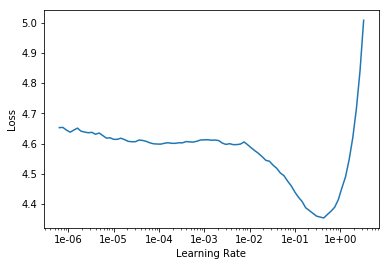

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


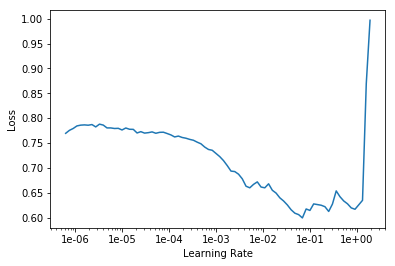

In [155]:
learn.lr_find()
learn.recorder.plot()

In [156]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.394164,0.360310,0.859037,00:08


In [133]:
#We’ll fine-tune the classifier with gradual unfreezing:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.308738,0.762661,0.731034,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.216084,0.771358,0.661948,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.198597,0.812495,0.743495,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.129306,1.273443,0.711694,00:17
1,0.132761,0.932274,0.719470,00:17
2,0.118099,0.988865,0.713289,00:17
3,0.126176,1.302860,0.694447,00:17


In [157]:
learn.predict(" what the flooding dance performance")

(Category Unrelated, tensor(1), tensor([0.4744, 0.5256]))

In [158]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,4086,311
1,1103,4531


In [159]:
from sklearn.metrics import classification_report

#classification_report(df_test['label'], predictions )
classification_report(targets, predictions )

'              precision    recall  f1-score   support\n\n           0       0.93      0.79      0.85      5189\n           1       0.80      0.94      0.87      4842\n\n    accuracy                           0.86     10031\n   macro avg       0.87      0.86      0.86     10031\nweighted avg       0.87      0.86      0.86     10031\n'

In [160]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(targets, predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.78


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.78')

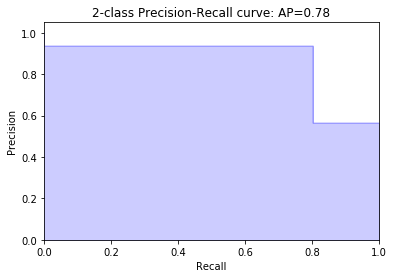

In [161]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(predictions, targets)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

     precision    recall  f1-score   support
     \n\n
   0       0.97      0.44      0.61      5189
   \n  
   1       0.62      0.99      0.76      4842
   \n\n   
   accuracy                           0.71     10031
   \n 
   macro avg       0.80      0.72      0.69     10031
   \n
   weighted avg       0.80      0.71      0.68     10031
   \n'